## Exploratory Analysis

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import os # accessing directory structure
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.


import seaborn as sb
import matplotlib.pyplot as plt # plotting
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import pprint as pp
import pickle
import re
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Open the pickled cleaned, transformed data
with open('cleaned_product_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


In [17]:
df.shape

(1037336, 10)

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    # For displaying purposes, pick columns that have between 1 and 50 unique values 
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), 
               dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    # keep columns where there are more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 1]] 
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns\
        ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    # keep columns where there are more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', 
                          ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Distribution graphs (histogram/bar graph) of sampled columns:

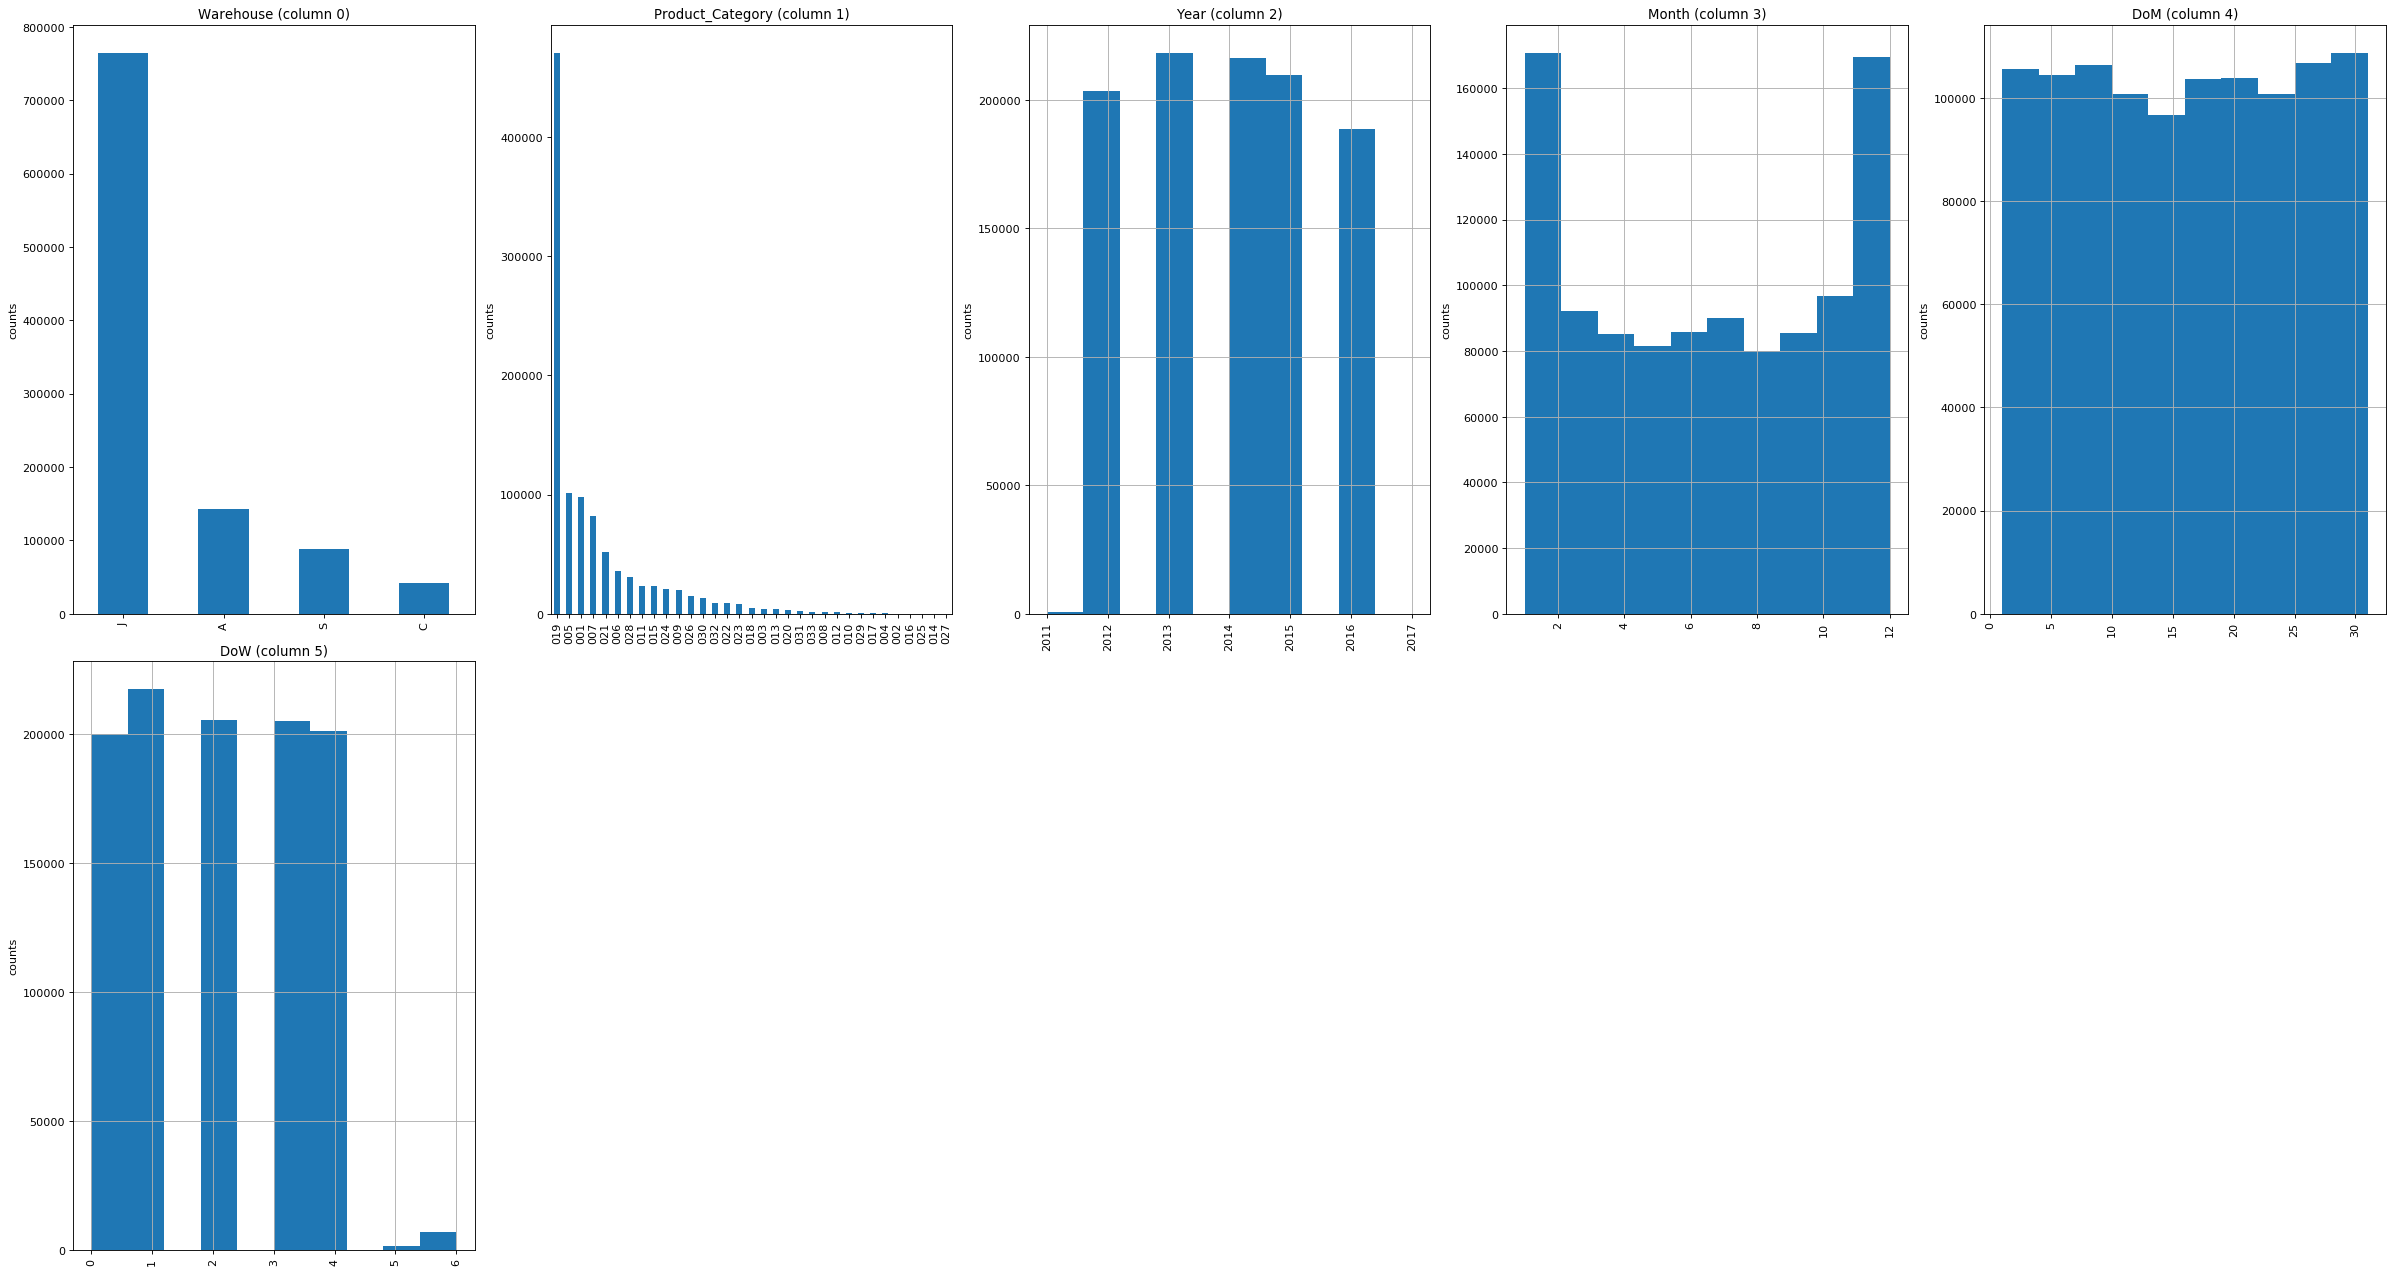

In [8]:
plotPerColumnDistribution(df, 10, 5)
rcParams['axes.labelsize'] = 10

#### Initial visualization of the ditribution of the target variable (Order_Demand)

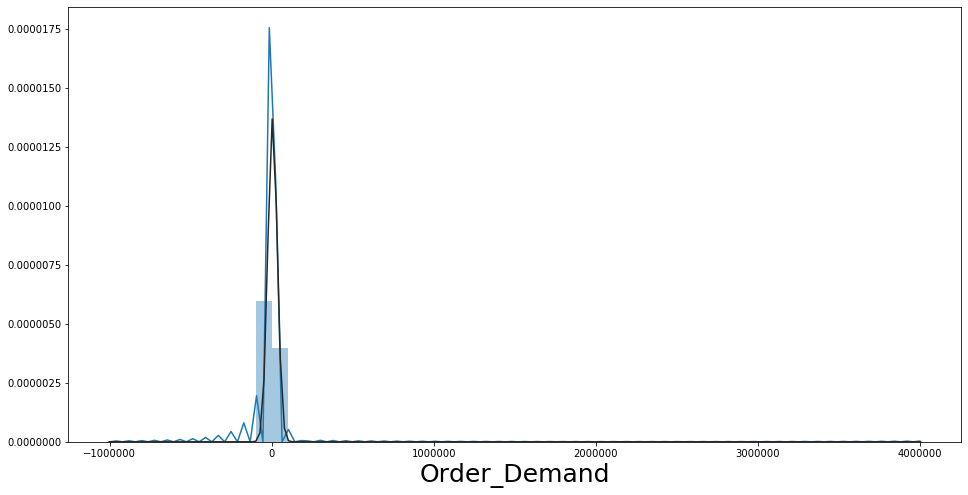

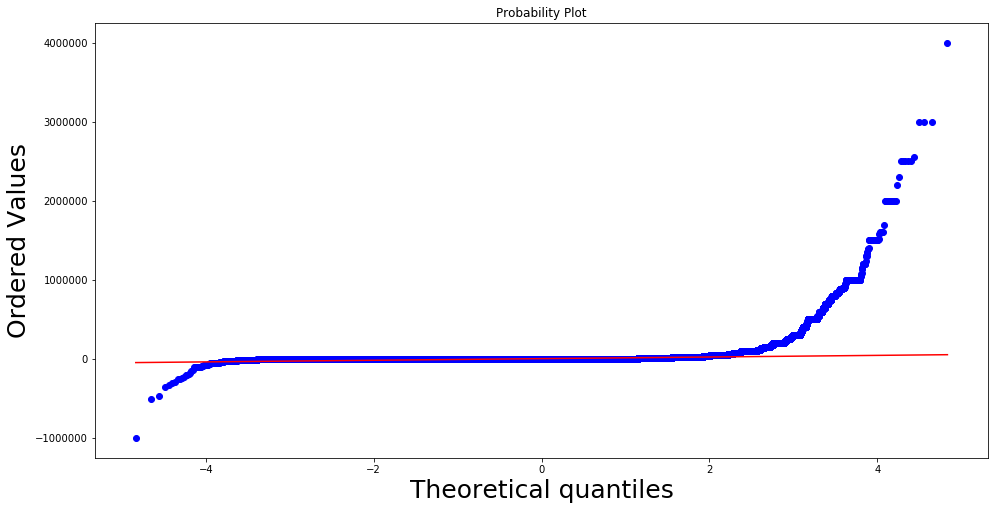

In [9]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,8
rcParams['axes.labelsize'] = 25
sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()


In [42]:
### Check the cumulative sum of demand. Note the uniformity of the accumulation

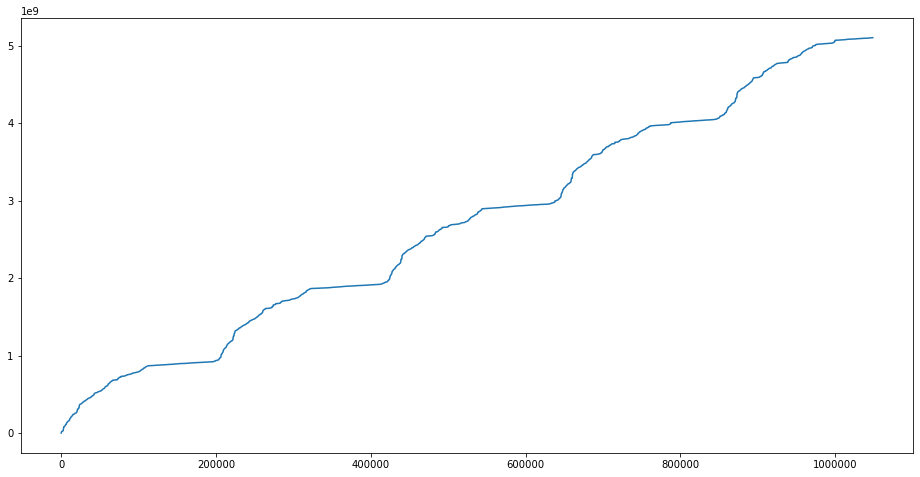

In [10]:
df['Order_Demand'].cumsum().plot()

#### Python has method to view the skew as one number

In [11]:
df['Order_Demand'].skew()

31.304715485625493

#### Univariate Analysis - Warehouse, Product Category.

In [13]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

J    764447
A    142335
S     88200
C     42354
Name: Warehouse, dtype: int64

In [14]:
#Units shipped by warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)

#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.
#4,375 units per order v. 11,725

,Order_Demand,Year,Month,Week,DoM,DoW
Warehouse,,,,,,
J,3344521718,1.539586e+09,4949878.0,20311746.0,11848624.0,1545204.0
S,1034227618,1.776101e+08,574077.0,2344139.0,1393727.0,177622.0
C,581845212,8.530831e+07,284699.0,1162894.0,676912.0,81890.0
A,143257683,2.866500e+08,942029.0,3871609.0,2237704.0,293282.0


33


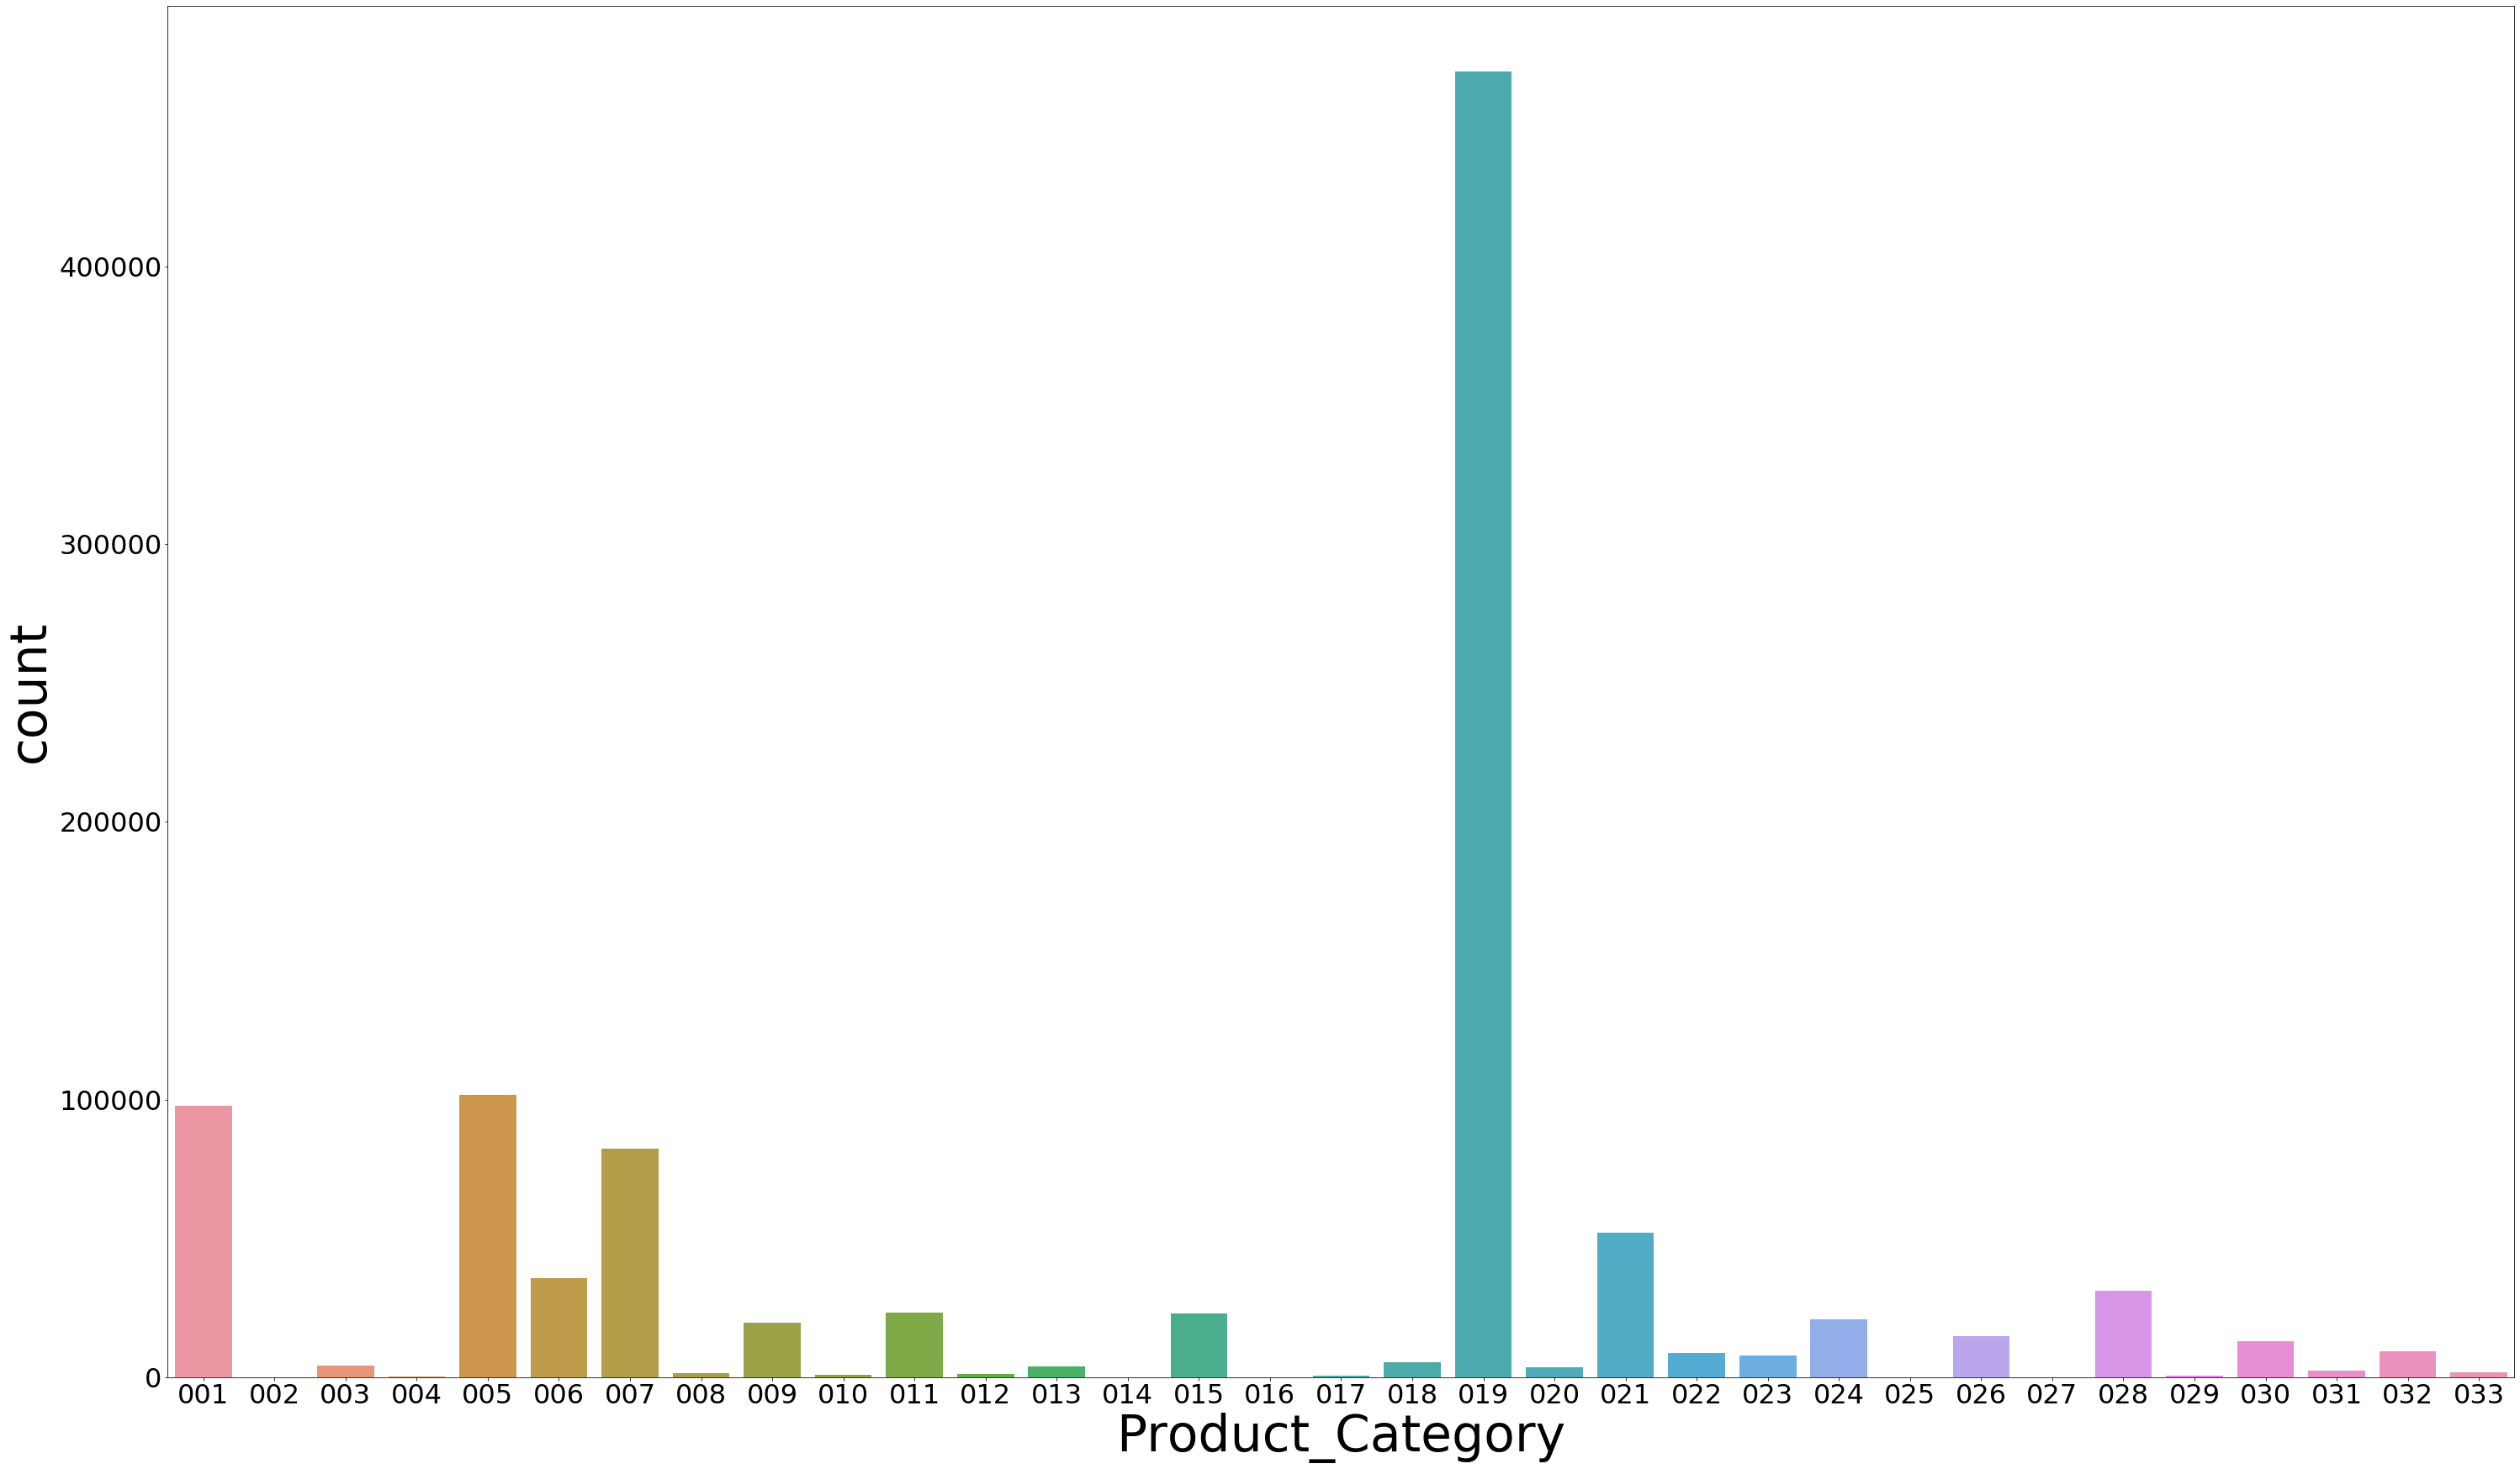

In [15]:
#Product Category.
plt.rcParams.update({'font.size': 32})
print (len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 50,30
rcParams['axes.labelsize'] = 60
sb.countplot(df['Product_Category'].sort_values(ascending = True));

#There's a lot of orders on category19.

Bivariate Analysis - Warehouse, Product Category with target variable.

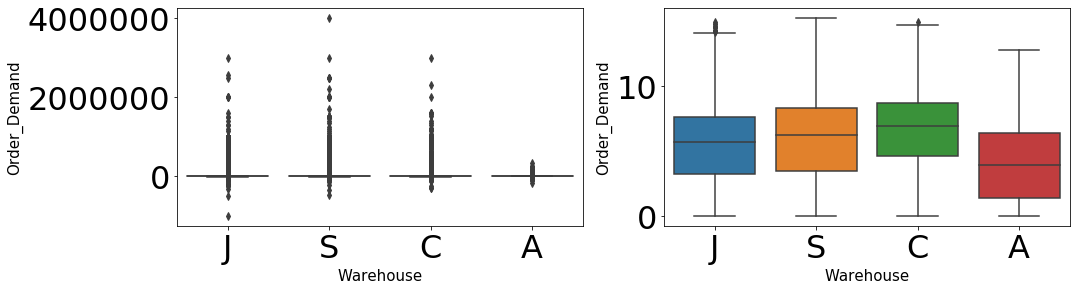

In [49]:
#Lets check the orders by warehouse.

#Checking with Boxplots
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,4
rcParams['axes.labelsize'] = 15
f, axes = plt.subplots(1, 2)
#Regular Data
fig3 = sb.boxplot( df['Warehouse'],df['Order_Demand'], ax = axes[0])
#Data with Log Transformation
fig4 = sb.boxplot( df['Warehouse'], np.log1p(df['Order_Demand']),ax = axes[1])

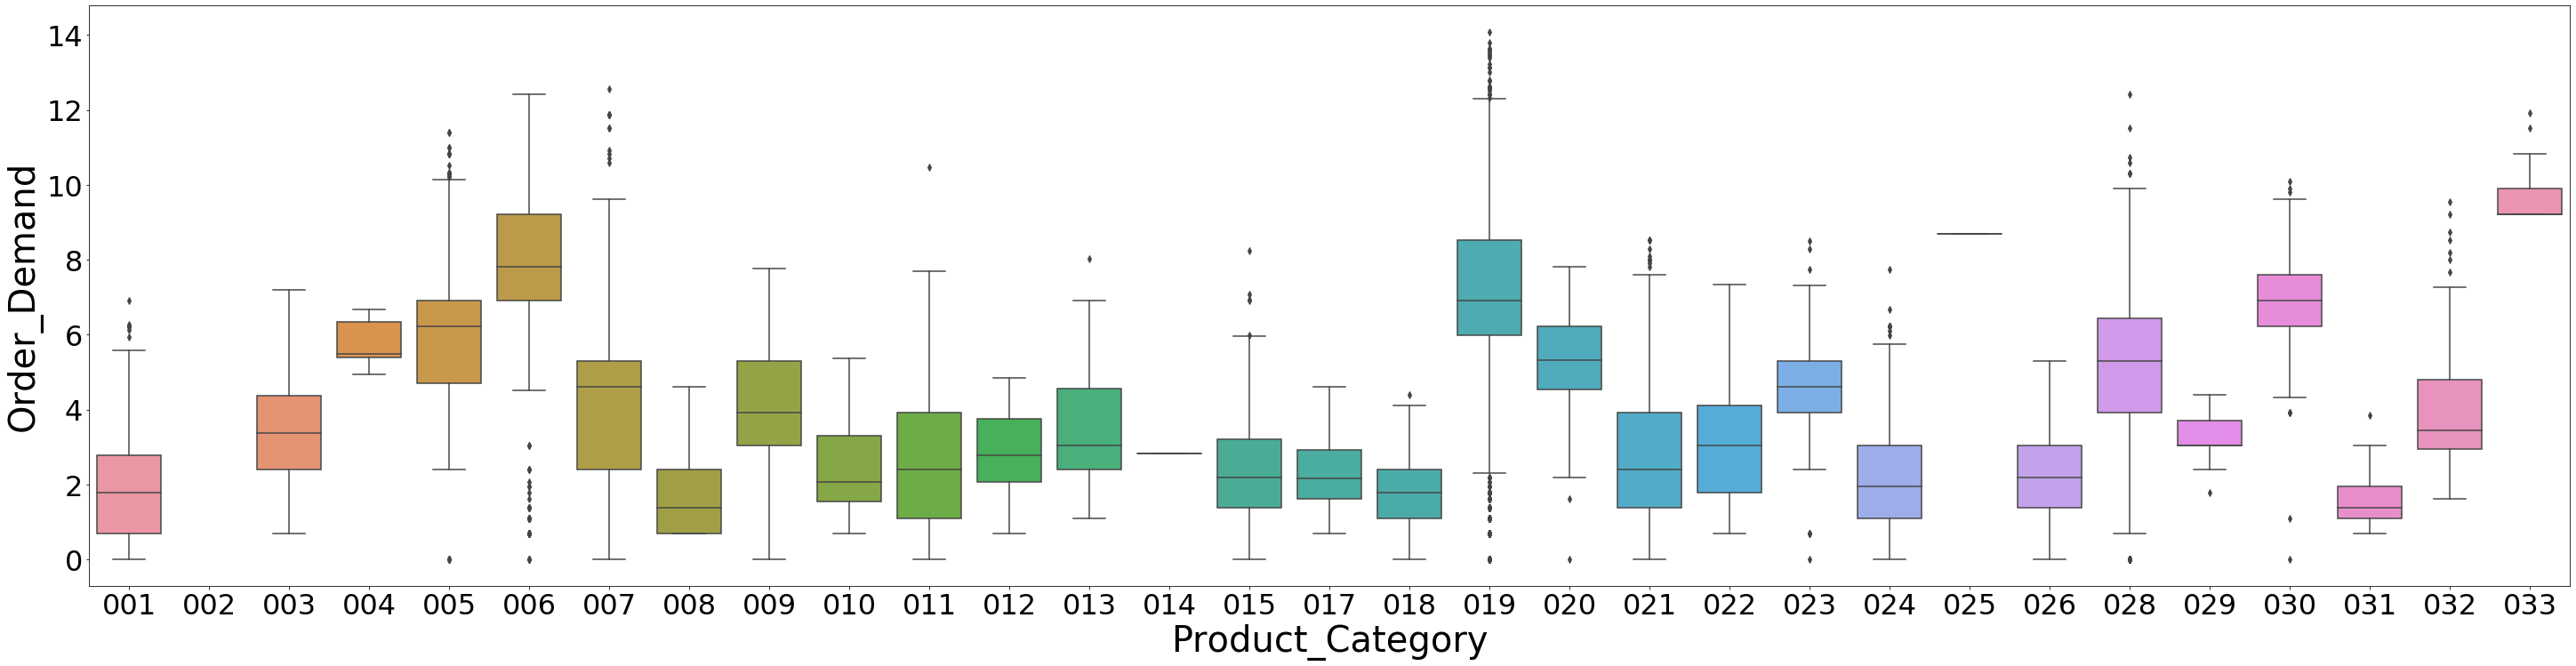

In [19]:
#Check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
rcParams['axes.labelsize'] = 40
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5

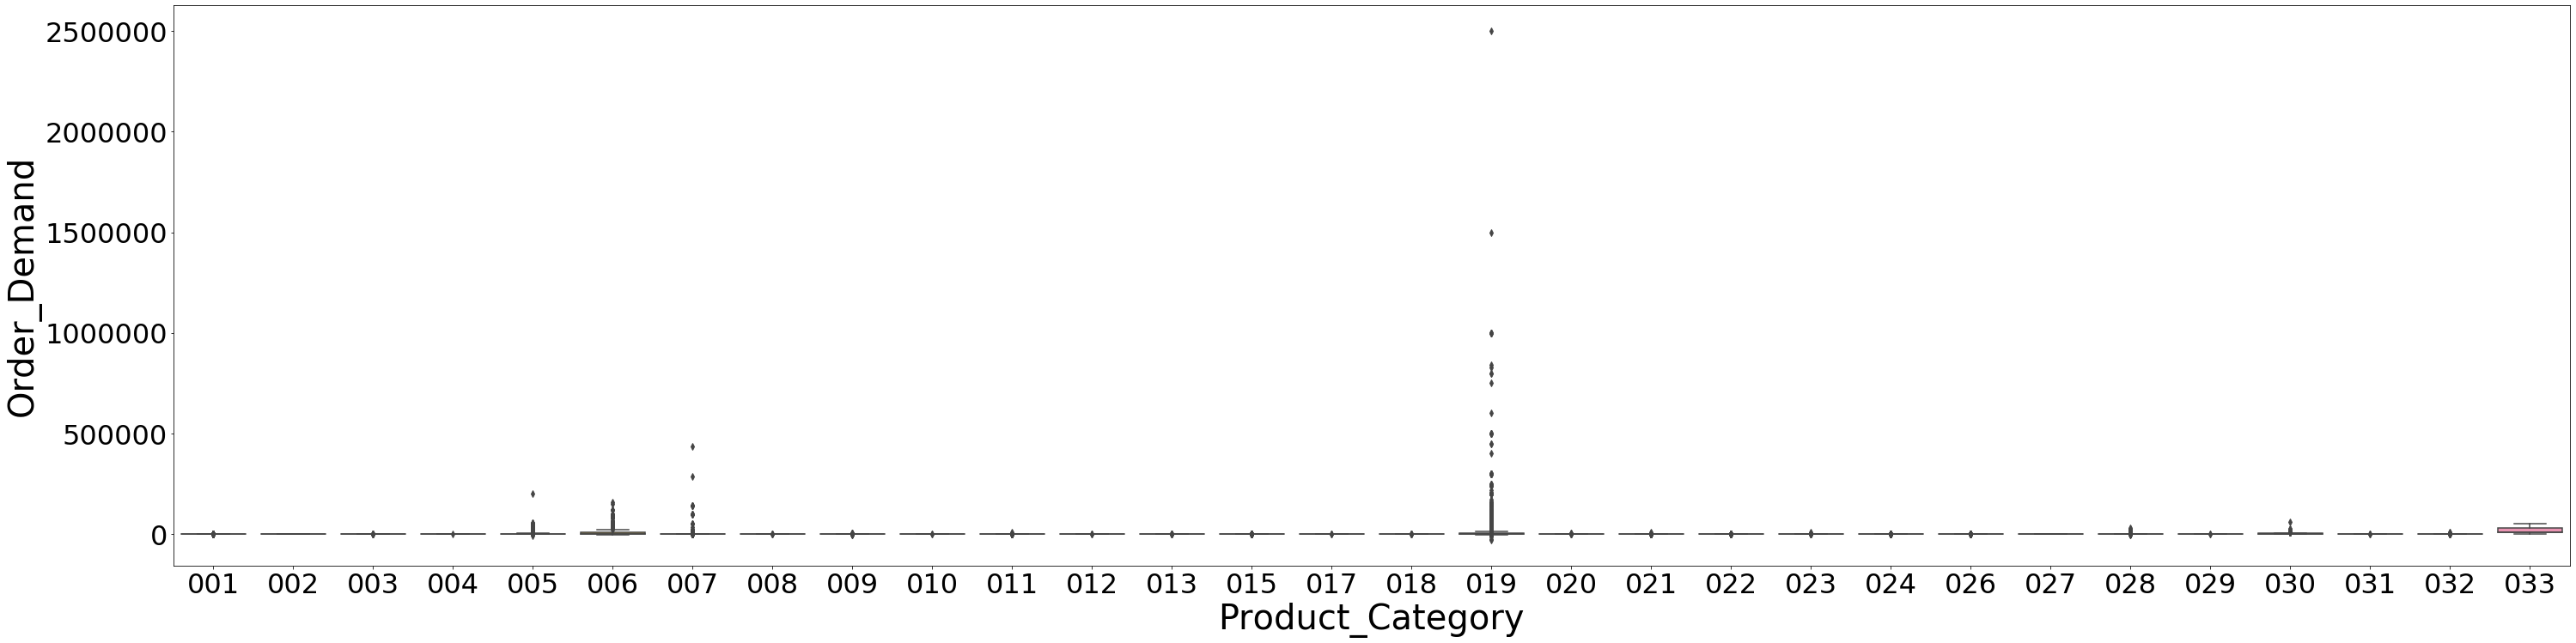

In [20]:
#Check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
rcParams['axes.labelsize'] = 40
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),df_temp['Order_Demand'])
del df_temp, fig5

Bivariate Analysis - Warehouse, Product Category with target variable.

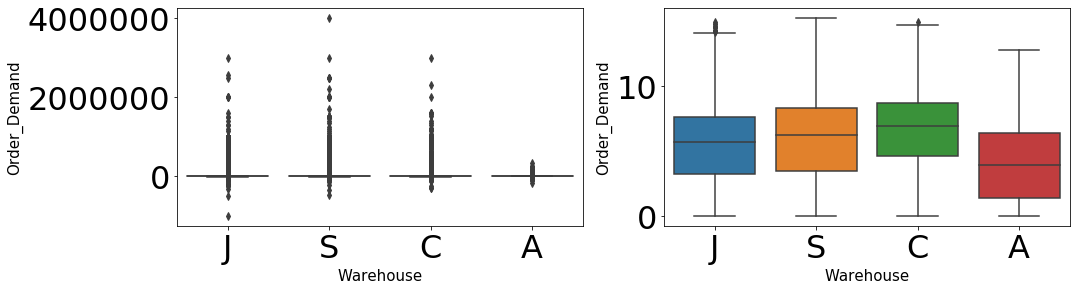

In [23]:
#Lets check the orders by warehouse.

#Checking with Boxplots
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,4
rcParams['axes.labelsize'] = 15
f, axes = plt.subplots(1, 2)
#Regular Data
fig3 = sb.boxplot( df['Warehouse'],df['Order_Demand'], ax = axes[0])
#Data with Log Transformation
fig4 = sb.boxplot( df['Warehouse'], np.log1p(df['Order_Demand']),ax = axes[1])

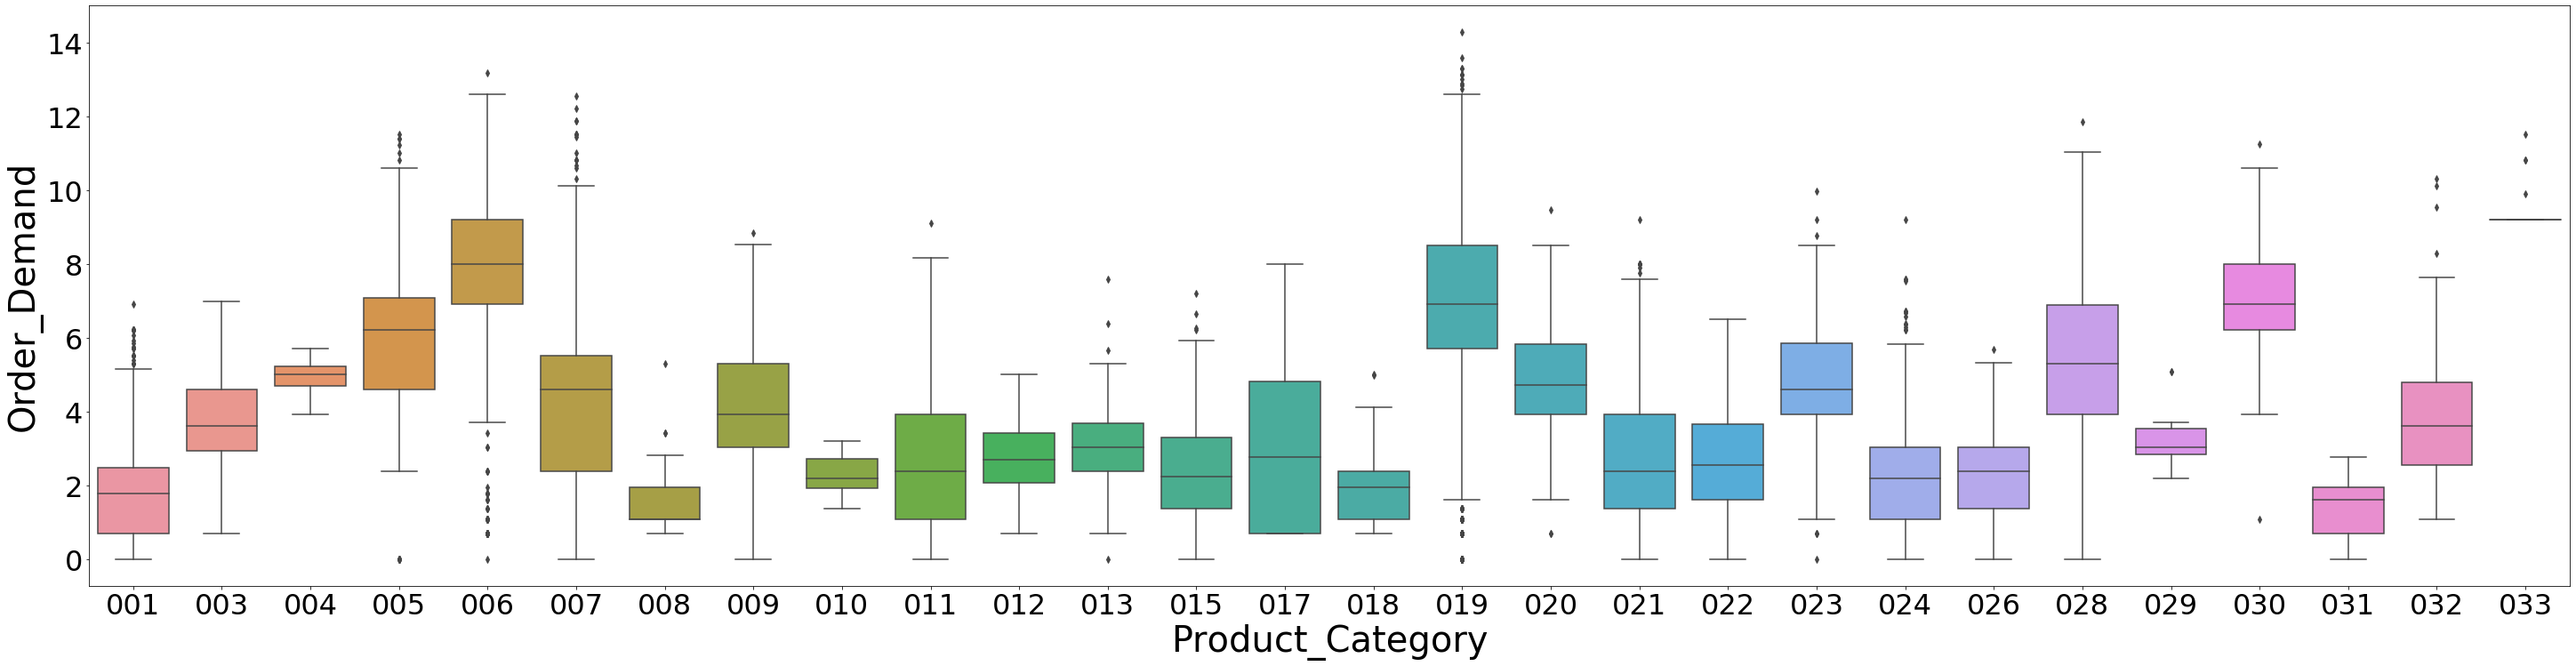

In [24]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
rcParams['axes.labelsize'] = 40
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5

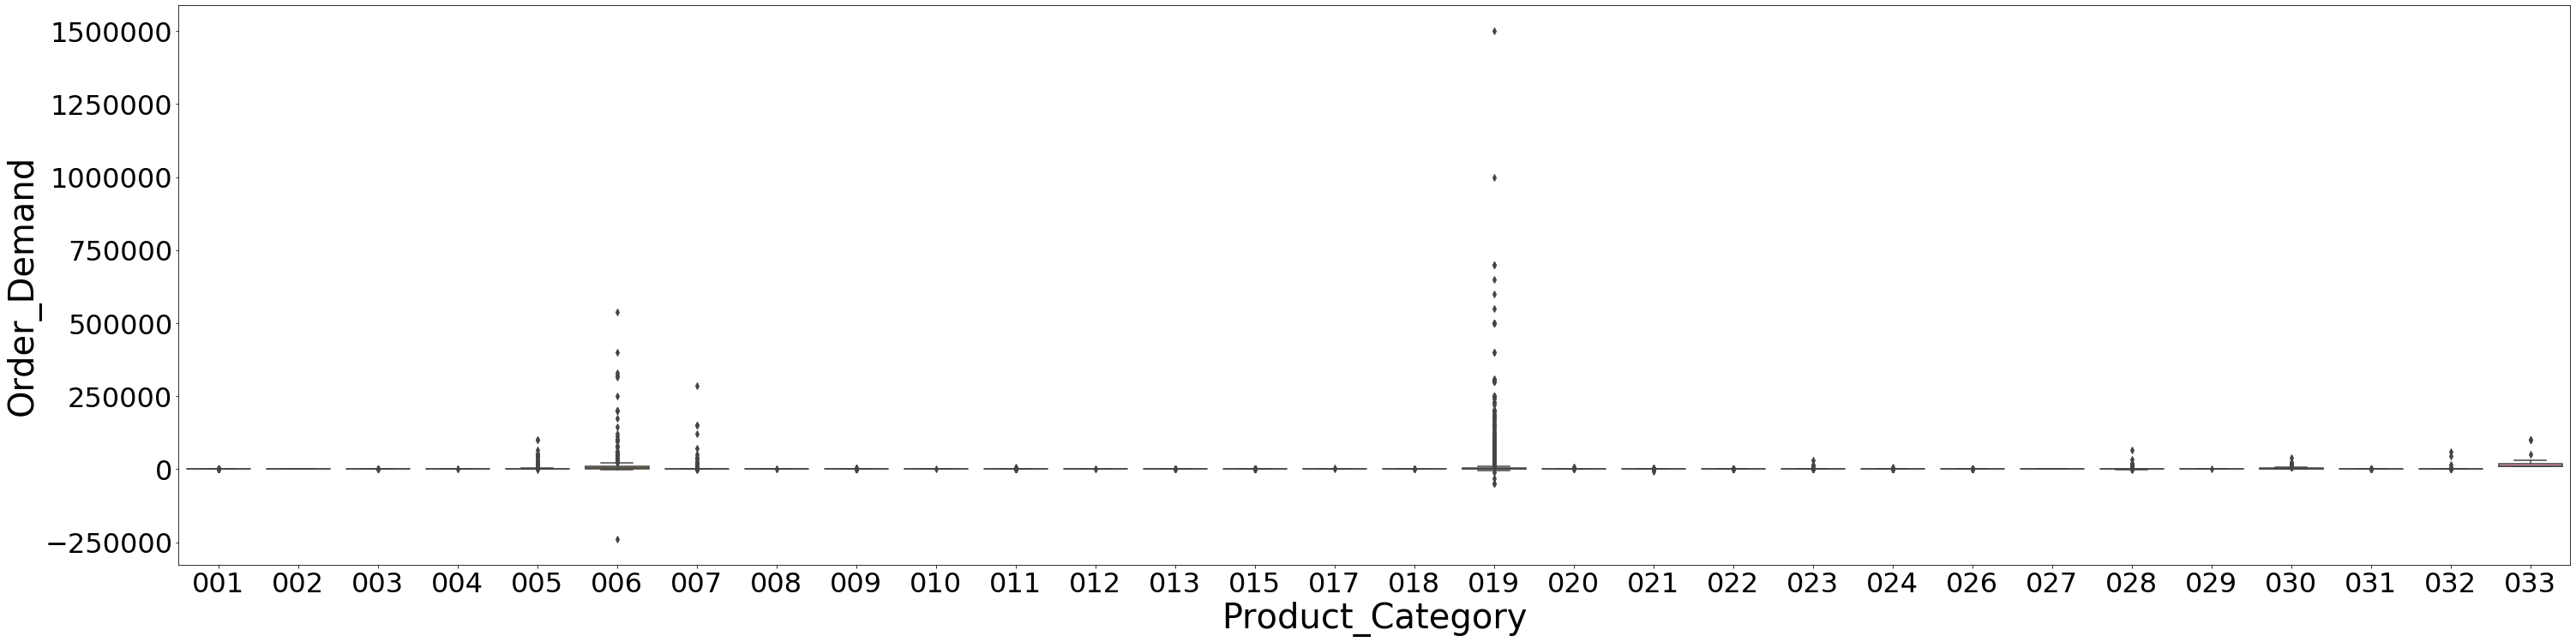

In [25]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
rcParams['axes.labelsize'] = 40
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),df_temp['Order_Demand'])
del df_temp, fig5

In [27]:
df_19 = df.loc[df['Product_Category'] == '019']
df_19

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
63,1234,J,019,2012-04-25,1000,2012.0,4.0,17.0,25.0,2.0
64,1451,J,019,2012-01-12,1000,2012.0,1.0,2.0,12.0,3.0
65,1274,J,019,2012-01-16,1000,2012.0,1.0,3.0,16.0,0.0
66,1274,J,019,2012-01-24,1000,2012.0,1.0,4.0,24.0,1.0
67,1274,J,019,2012-01-24,1000,2012.0,1.0,4.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1048535,1213,J,019,2016-10-26,100,2016.0,10.0,43.0,26.0,2.0
1048536,1391,J,019,2016-10-26,100,2016.0,10.0,43.0,26.0,2.0
1048537,1391,J,019,2016-11-16,100,2016.0,11.0,46.0,16.0,2.0
1048538,1213,J,019,2016-11-21,800,2016.0,11.0,47.0,21.0,0.0


In [28]:
df_19.shape

(470266, 10)

In [29]:
df_19.Product_Code.nunique()

534

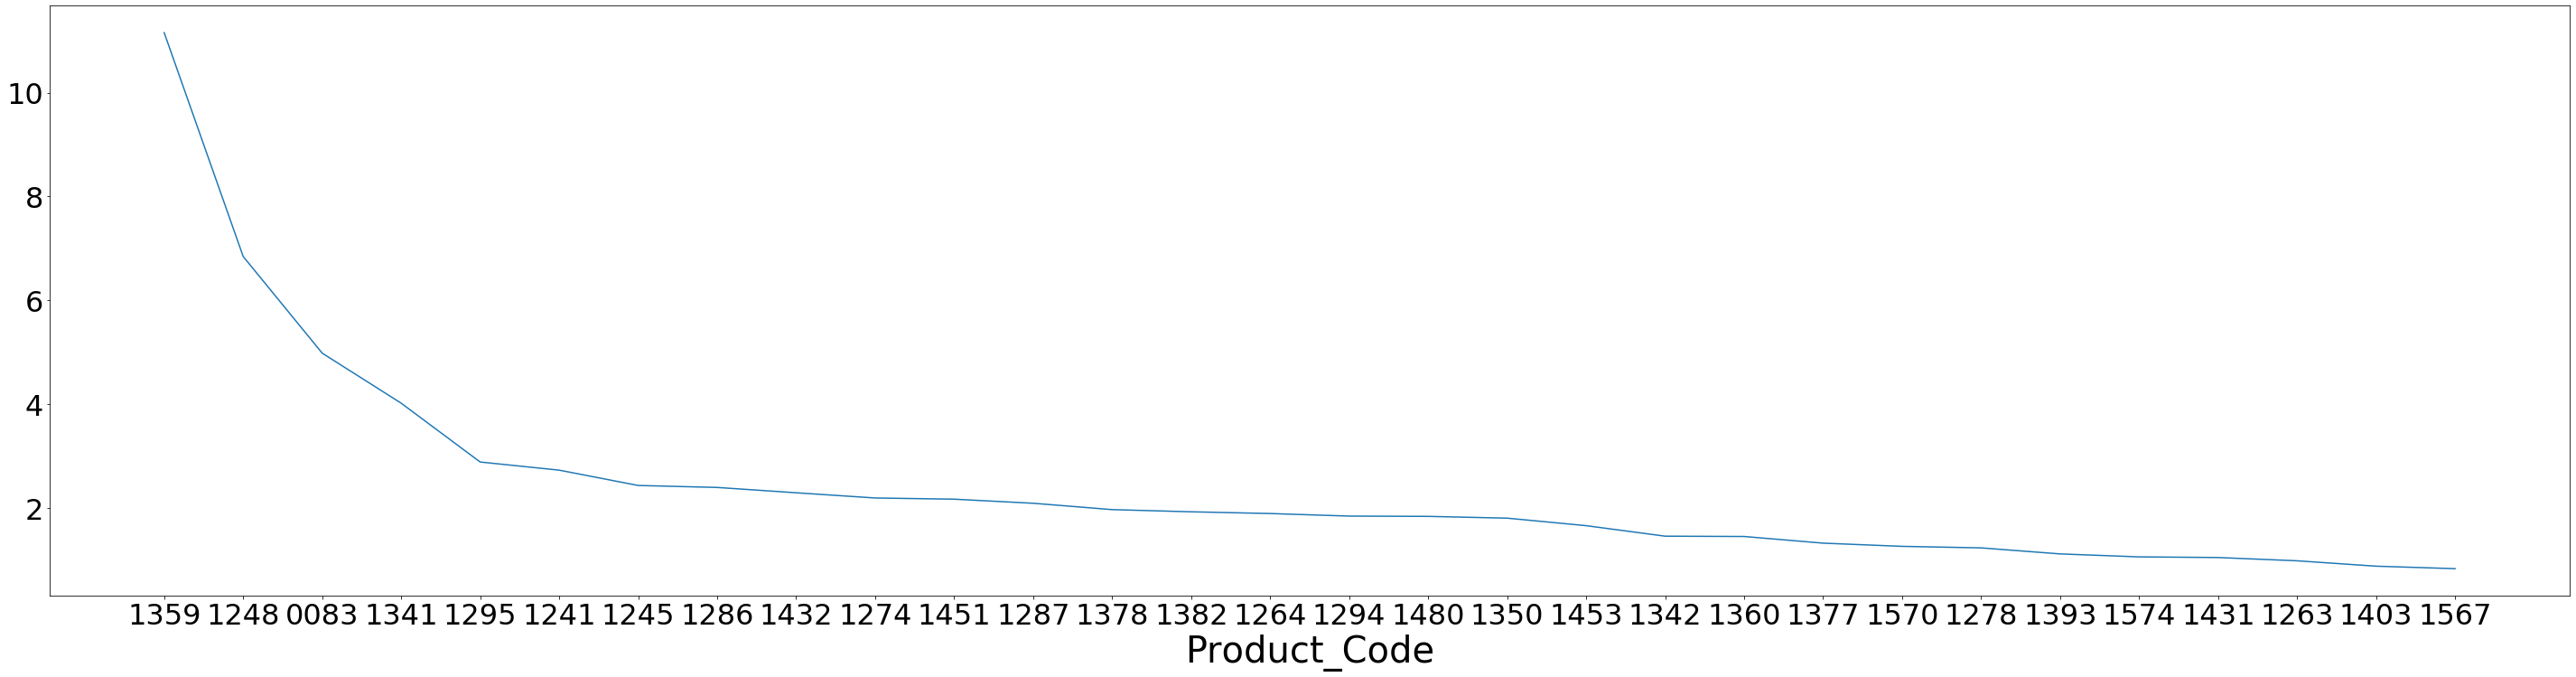

In [30]:
total_order_demand = df_19.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False).sum()
order_by_percent = (df_19.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100)
order_by_percent.iloc[:30].plot(xticks = range(30))

In [31]:
product_order_demand = df.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False).sum()
(df.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100).head()

Product_Code
1359    11.154776
1248     6.846925
0083     4.986650
1341     4.023336
1295     2.890938
Name: Order_Demand, dtype: float64

In [33]:
df_19 = df.loc[df['Product_Category'] == '019']
df_19

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
63,1234,J,019,2012-04-25,1000,2012.0,4.0,17.0,25.0,2.0
64,1451,J,019,2012-01-12,1000,2012.0,1.0,2.0,12.0,3.0
65,1274,J,019,2012-01-16,1000,2012.0,1.0,3.0,16.0,0.0
66,1274,J,019,2012-01-24,1000,2012.0,1.0,4.0,24.0,1.0
67,1274,J,019,2012-01-24,1000,2012.0,1.0,4.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1048535,1213,J,019,2016-10-26,100,2016.0,10.0,43.0,26.0,2.0
1048536,1391,J,019,2016-10-26,100,2016.0,10.0,43.0,26.0,2.0
1048537,1391,J,019,2016-11-16,100,2016.0,11.0,46.0,16.0,2.0
1048538,1213,J,019,2016-11-21,800,2016.0,11.0,47.0,21.0,0.0


In [34]:
df_19.shape

(470266, 10)

In [35]:
df_19.Product_Code.nunique()

534

### Very few products have significant contribution to total demand
At this stage not ready to limit any of the demand data. Later analysis my drill down to product code level. 

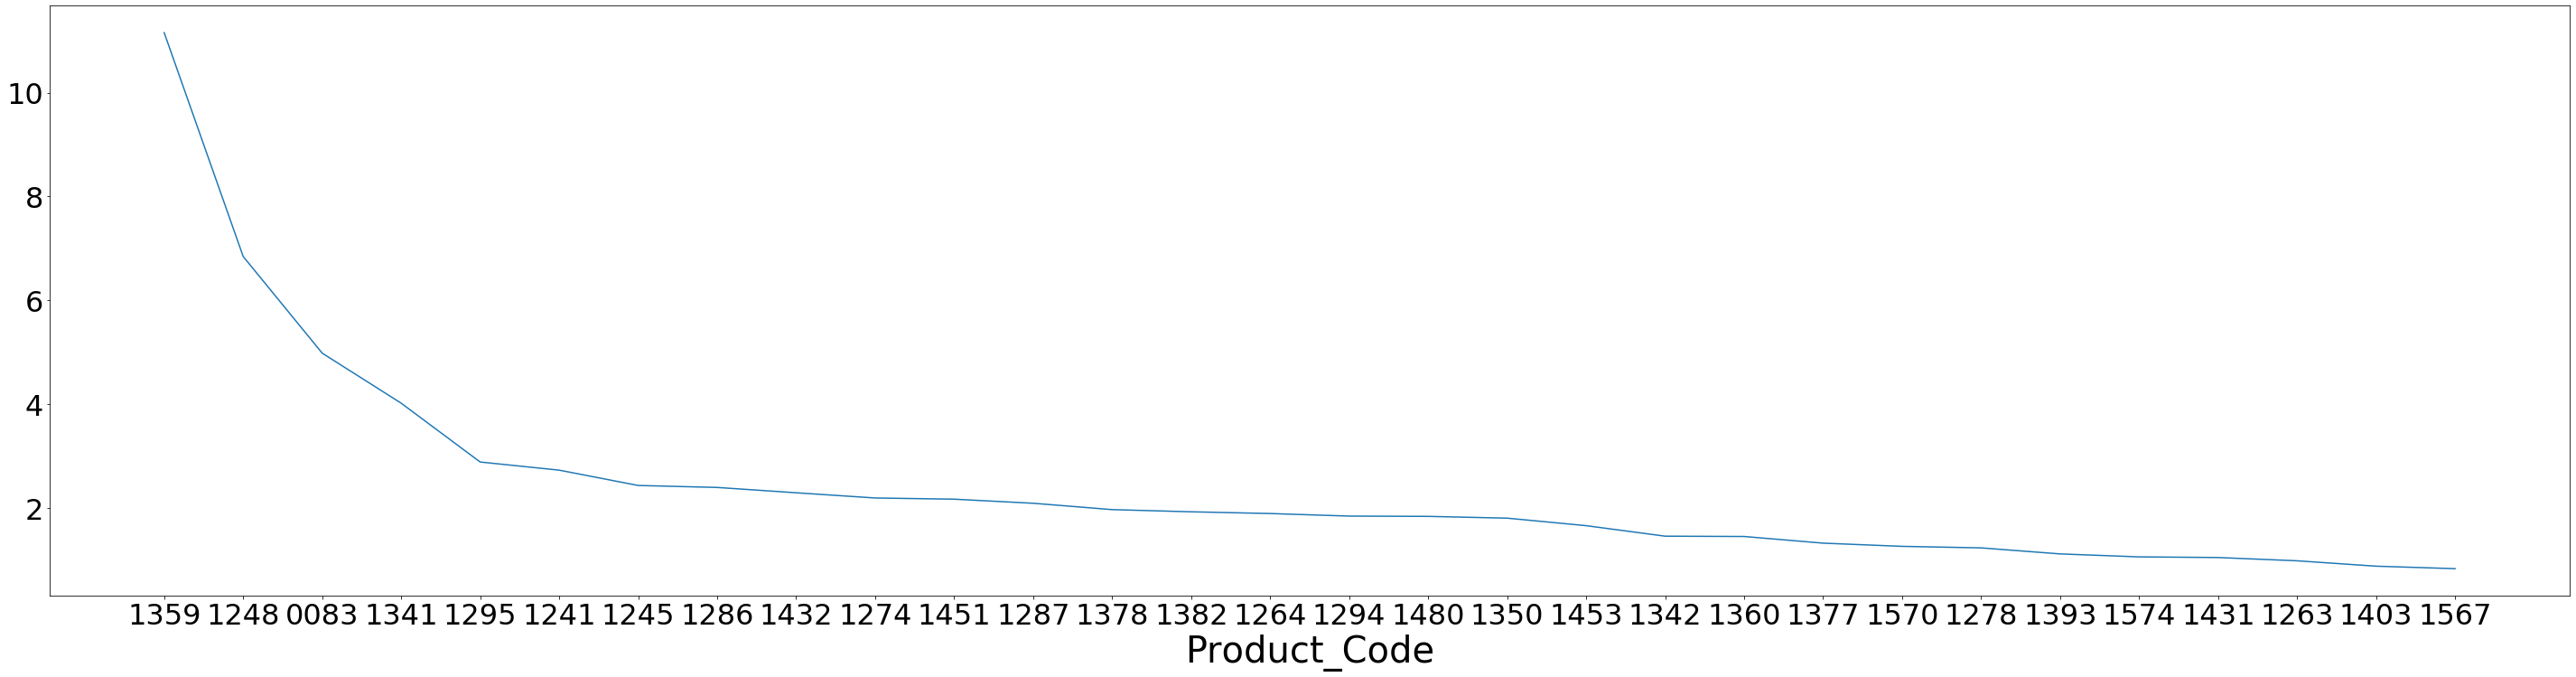

In [36]:
total_order_demand = df_19.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False).sum()
order_by_percent = (df_19.groupby(['Product_Code']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100)
order_by_percent.iloc[:30].plot(xticks = range(30))

In [37]:
order_by_percent.head(12)

Product_Code
1359    11.154776
1248     6.846925
0083     4.986650
1341     4.023336
1295     2.890938
1241     2.734367
1245     2.439377
1286     2.401338
1432     2.298802
1274     2.198560
1451     2.175455
1287     2.096873
Name: Order_Demand, dtype: float64

In [38]:
top_12_codes = order_by_percent.head(12).index.to_list()

In [54]:
#Pickle top 12% data for possible use later
with open('df_top_twelve.pkl', 'wb') as to_write:
    pickle.dump(df_top_twelve, to_write)

### Initial EDA complete.  Next step to check for stationarity in next notebook.